## Data Wrangling and EDA

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
# Loading user table
user_data = pd.read_csv('takehome_users.csv', encoding = 'latin-1')

In [3]:
user_data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
user_data['creation_time'] = pd.to_datetime(user_data['creation_time'])

In [5]:
user_data['last_session_creation_time'] = pd.to_datetime(user_data['last_session_creation_time'], unit='s')

In [6]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [7]:
# Loading user engagement table
user_summary = pd.read_csv('takehome_user_engagement.csv')

In [8]:
user_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [9]:
user_summary['time_stamp'] = pd.to_datetime(user_summary['time_stamp'])
user_summary = user_summary.set_index('time_stamp', drop= True)

In [10]:
from datetime import timedelta

def label_adopted(x):    
    "takes a users input and returns whether or not they have been active within any 7-day period"
    df_temp = user_summary.loc[user_summary['user_id'] == x] #select out rows of this user
    df_temp = df_temp.resample('D').mean().dropna() #resample to show if active in a day. .mean() is just of 1
    adopted = 0
    for i in range(len(df_temp)-2): #loop over active days till the second to last day
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [11]:
#apply to user df to label users as adopted=true 
user_data['adopted_user'] = user_data['object_id'].apply(label_adopted)

In [12]:
print(sum(user_data['adopted_user']))
print(sum(user_data.adopted_user)/len(user_data.adopted_user))

1656
0.138


In [13]:
#now set that to datetime
user_data['last_session_creation_time'] = pd.to_datetime(user_data['last_session_creation_time'])
#subtract to find time active
user_data['usage_length'] = user_data['last_session_creation_time'] - user_data['creation_time']
#lets settle for seconds instead of days to make the time differences more distinct
user_data['usage_length'] = [x.total_seconds() for x in user_data['usage_length']]

In [14]:
user_data['email_provider'] = [x.split('@')[1] for x in user_data.email]#select out the domain
top_emails = user_data.email_provider.value_counts().index[:6]
#label anything not in the top 5 as other
user_data['email_provider'] = [x if x in top_emails else 'other' for x in user_data.email_provider]

In [15]:
user_data.invited_by_user_id = user_data.invited_by_user_id.fillna(0)

In [16]:
feature_df = user_data.iloc[:,4:]
feature_df = feature_df.drop('last_session_creation_time', axis=1)
feature_df['usage_length'] = feature_df['usage_length'].fillna(0)

In [17]:
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
creation_labels = gle.fit_transform(user_data['creation_source'])
feature_df.creation_source = creation_labels

org_id_labels = gle.fit_transform(user_data['org_id'])
feature_df.org_id = org_id_labels

invited_labels = gle.fit_transform(user_data['invited_by_user_id'])
feature_df.org_id = invited_labels

email_labels = gle.fit_transform(user_data['email_provider'])
feature_df.email_provider = email_labels

In [18]:
feature_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,usage_length,email_provider
0,0,1,0,2325,10803.0,0,0.0,6
1,1,0,0,56,316.0,1,11750400.0,2
2,1,0,0,298,1525.0,0,0.0,2
3,0,0,0,1104,5151.0,0,86400.0,6
4,0,0,0,1127,5240.0,0,432000.0,6


## Modeling

In [19]:
from sklearn.model_selection import train_test_split

#set up data by seperating out the labels, then split for cross validation
data = feature_df.drop('adopted_user', axis=1)
labels = feature_df.adopted_user

X_train, y_train, X_test, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

In [20]:
from sklearn.ensemble import RandomForestClassifier

#train and test classifier
rf = RandomForestClassifier(class_weight='balanced_subsample')

rf.fit(X_train, X_test)

rf.score(y_train, y_test)

0.9704545454545455

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

#print out classification report and confusion matrix
y_pred = rf.predict(y_train)

print(classification_report(y_test, y_pred))

cm= confusion_matrix(y_test,y_pred)
print('confusion matrix:')
print(cm)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3407
           1       0.91      0.88      0.89       553

    accuracy                           0.97      3960
   macro avg       0.94      0.93      0.94      3960
weighted avg       0.97      0.97      0.97      3960

confusion matrix:
[[3359   48]
 [  69  484]]


In [22]:
#make a df that displays the cofficients indexed by feature name
feature_importance = pd.DataFrame()
feature_importance['coef'] = rf.feature_importances_
feature_importance = feature_importance.set_index(data.columns)
feature_importance.coef.nlargest(10)

usage_length                  0.921525
org_id                        0.022744
invited_by_user_id            0.021863
email_provider                0.015763
creation_source               0.010982
opted_in_to_mailing_list      0.003579
enabled_for_marketing_drip    0.003544
Name: coef, dtype: float64

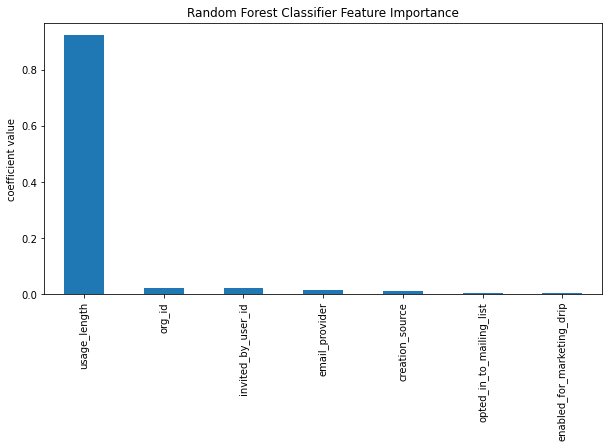

In [23]:
#plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
(feature_importance['coef']).nlargest(10).plot(kind='bar', x=feature_importance.index)
plt.title('Random Forest Classifier Feature Importance')
plt.ylabel('coefficient value')
plt.show()